<a href="https://colab.research.google.com/github/PinChunPai/Cat_breeds_classification/blob/main/Cat_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cat breeds classification**
This is a side project for computer vision, using the famous Stanford dog dataset. In this project I would like to use the pre-trained vit from google to train a cat-breed-claasification model by transfer learning. Goggle vit conatins 7 breeds of cats in its 1000 calsses. We are going to use a dataset from Kaggle labeling 67 breeds. So it's a good test of how pre-trained model can be improved by fine-tuning.
The model will be posted to hugging space so everyone can use it on-line.

## **Steps**
This project contains the following steps:
1. Access data: I will download the data from Kaggle and store it in my colud derive.
2. EDA
3. train-test split to get three datasets: train_ds, valid_ds and test_ds
4. Install pre-trained vision transformer model and clarify how to prepare data for it
5. Using the information from step 4, construct two different transformations. They account for:
* Resize, augement, to_tensor and normalize train_ds
* Resize and normalize test_ds and valid_ds
6. Construct relevant dataloaders
7. Define fine-tuned model
8. Train model and fine tune parameters
9. Train model on all availale labelled datas to get the maximum information.
10.Upload model to Hugging face and Gradio.  


## **Setup**
Firstly, we import and install packages which will be used later. Start from fundamental commands for i/o, algebra and drawing.

In [1]:
## Fundamental packages for reading/writing files, algebra and plot
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 ### used for reading/writing images
import warnings
warnings.filterwarnings("ignore") ## ignore annoying warnings
from sklearn.model_selection import train_test_split ## For data preprocess

Then we import torch and relative packages used fo preprocess and load image datas

In [79]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

Now we install three packages:
* transformer: to use pre-trained vision transformer models
* evaluate: to provide various metrics to evaluate models
* gradio: to establish web demo

I am going to fix the version so I can use what I learn from class without worrying about version issues.

In [3]:
!pip install transformers==4.24.0
!pip install evaluate==0.3.0
!pip install gradio==3.12.0

## **1.Get data**
The dataset is stored in my google derive. So I define the relevant path for my derive. **This part should be modified on different enviroments.**

In this project I am going to use a cat breed dataset downloaded from [this Kaggle page](https://www.kaggle.com/datasets/knucharat/pop-cats). However the resourse can be tracked back to another [Petfinder](https://www.petfinder.com/developers/) \(available through [petpy](https://github.com/aschleg/petpy) \). The set I use in this project has been cleaned and it contains 20 common breeds, each containing 500 pictures. I further integrate the data and stored the reult in labels.csv.



In [4]:
path = '/content/drive/MyDrive/Project/Transformer_CV' ## It should be modified to the ACTUAL PATH storing dataset.

In [5]:
ls /content/drive/MyDrive/Project/Transformer_CV

Cat_breeds.ipynb  cats20/  create_list.ipynb  labels.csv


There are three objects being used:
* Cat_breeds.ipynb : This Colab file.
* cats20/ : The folder containing all labeled jpg pictures.
* labels.csv: Csv file storing ids for each image and corresponding labels.

create_list.ipynb is what I designed to interate data and the result is stored in labels.csv. It won't be used in the following code.


Let's take a look at labels.csv, which stores useful information.

In [6]:
all_data = pd.read_csv(os.path.join(path, 'labels.csv'))
all_data.head(5)

,id,breed
0,siamese_336.jpg,Siamese
1,siamese_143.jpg,Siamese
2,regdoll_199.jpg,Regdoll
3,norwegian_264.jpg,Norwegian Forest
4,bengal_254.jpg,Bengal


It provides names of pictures and the corresponding labels. Let's convert 'id' to the actually path.

In [102]:
all_data['id'] = path + '/cats20/' + all_data['id']
all_data.head(5)

,id,breed
0,/content/drive/MyDrive/Project/Transformer_CV/...,Siamese
1,/content/drive/MyDrive/Project/Transformer_CV/...,Siamese
2,/content/drive/MyDrive/Project/Transformer_CV/...,Regdoll
3,/content/drive/MyDrive/Project/Transformer_CV/...,Norwegian Forest
4,/content/drive/MyDrive/Project/Transformer_CV/...,Bengal


## **2. EDA**
'id' of each row is exactly the name of each picture. Using them we can read pictures from corresponding folders.

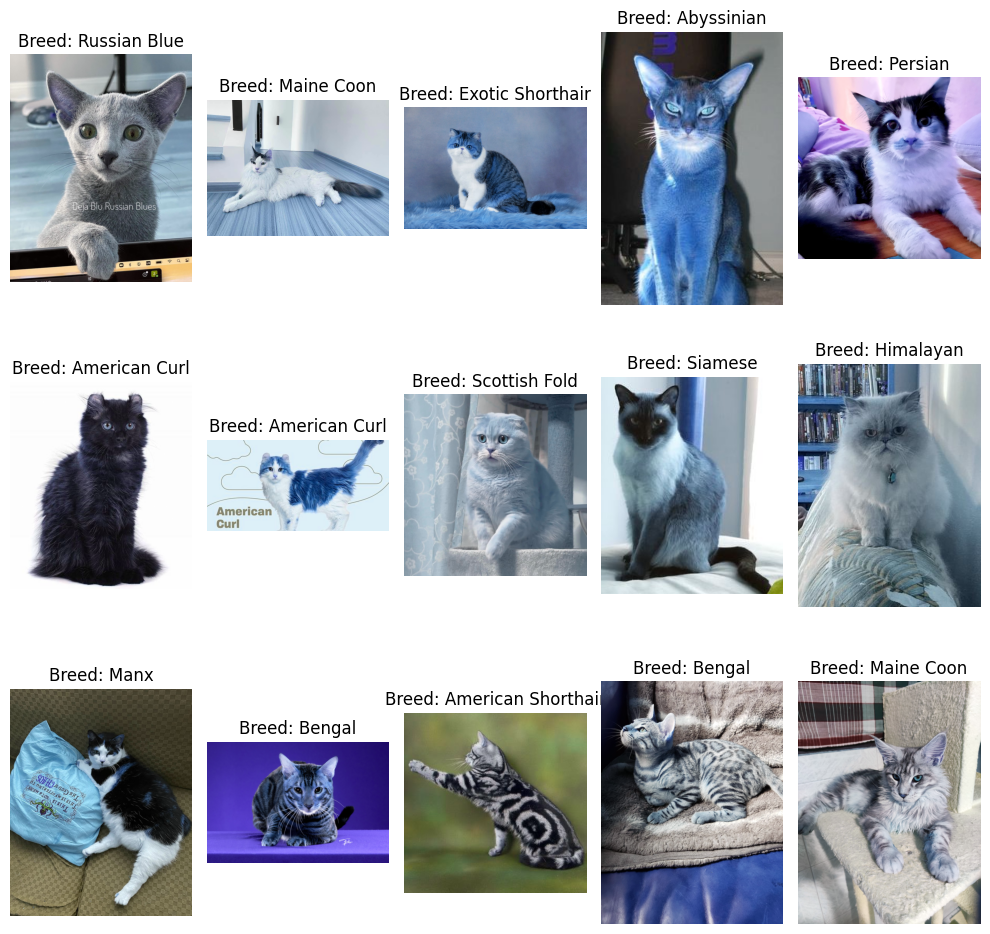

In [103]:
samples = all_data.sample(15)
plt.figure(figsize=(10, 10))

for i, index in enumerate(samples.index):
    plt.subplot(3,5, i + 1)
    img = cv2.imread(samples.loc[[index], "id"].values[0] )
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Breed: {samples.loc[[index],"breed"].values[0]}')

plt.tight_layout()
plt.show()

Notice that the sizes of pictures are different. They need to be resized in preprocessing step.

Before preprocessing, let's take a look at how the target feature(breed in this case) distributes.

In [104]:
all_data['breed'].value_counts()

Birman                502
Bombay                502
Siamese               501
Regdoll               501
Persian               501
Russian Blue          501
Abyssinian            501
Manx                  501
Sphynx                501
Egyptian Mau          501
American Curl         501
Exotic Shorthair      501
Maine Coon            501
Himalayan             501
Scottish Fold         501
Bengal                501
Munchkin              501
American Shorthair    500
Bristish Shorthair    500
Norwegian Forest      500
Name: breed, dtype: int64

We see that the distribution is not too imbalanced. Totally 120 breeds and max_num ~ 2* min_num. We can plot the value counts.

<Axes: >

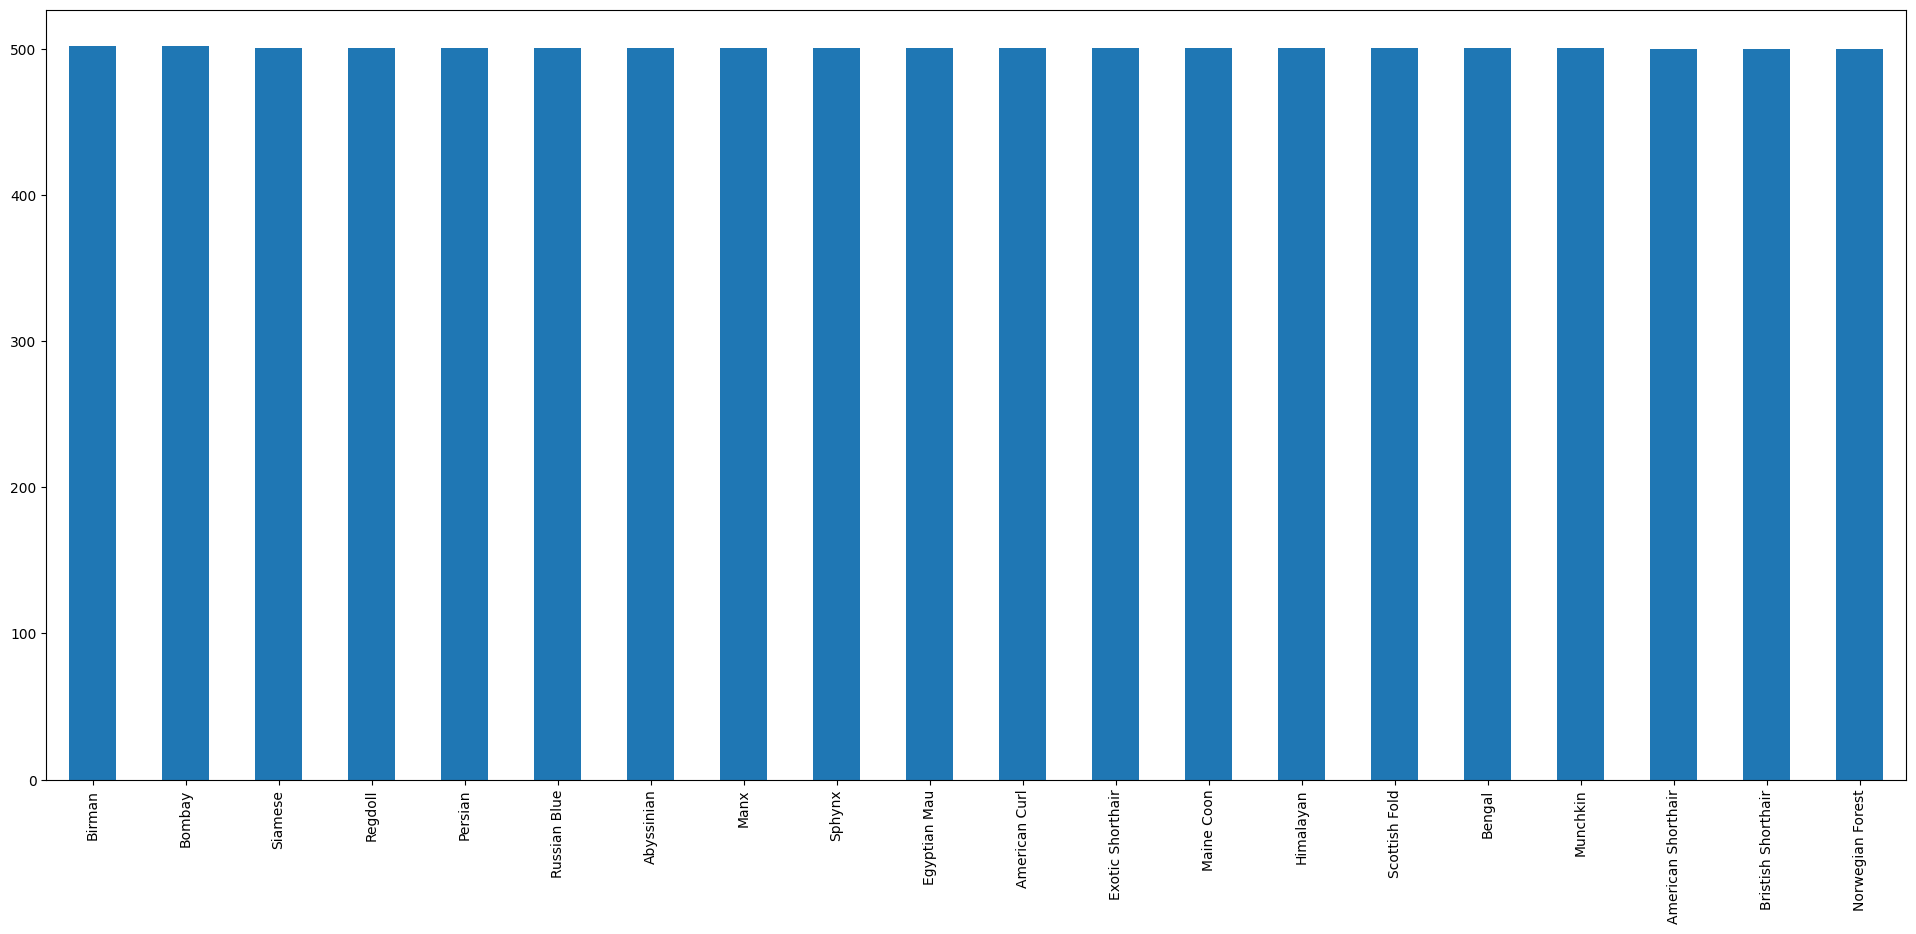

In [105]:
all_data['breed'].value_counts().plot.bar(figsize=(24,10))

Therefore we don't need to worry about distribution. We can use train_test_split to get training, validation and testing set.

In [106]:
X = all_data['id'].to_frame()
y = all_data['breed'].to_frame()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42, shuffle=True, stratify=y_train_val)

In [107]:
print((X_train.shape, y_train.shape))
print((X_val.shape, y_val.shape))
print((X_test.shape, y_test.shape))


((8025, 1), (8025, 1))
((992, 1), (992, 1))
((1002, 1), (1002, 1))


Now we get the three datasets.

## **Pre-Trained Model**
Before going to data preprocessing, we should take a look at the pre-trained model. Especially we want to look at format of its input and what it was trained for.



### **Install**
I will use vit provided by google, which is open sourced on [HuggingFace]()

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

model_id = 'google/vit-base-patch16-224'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(model_id).to(device)
model.eval()

In [30]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

It does normalize and resize automatically. But we may still want to address these process by ourselves so that we can do experiments later.

### **Test Pre-trained Model**

Take a random picture to test this pre-trained model.

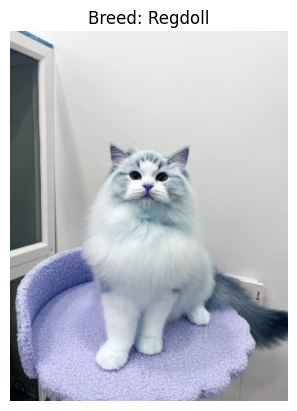

In [108]:
img = cv2.imread(all_data.loc[[3358], "id"].values[0] )
plt.imshow(img)
plt.axis('off')
plt.title(f'Breed: {all_data.loc[[3358],"breed"].values[0]}')
plt.show()

In [46]:
inp = feature_extractor(img, return_tensors="pt").to(device)

In [53]:
print(type(inp))

<class 'transformers.feature_extraction_utils.BatchFeature'>


In [41]:
oput = model(**inp)

In [36]:
oput.logits.shape

torch.Size([1, 1000])

In [37]:
torch.argmax(oput.logits, dim=1)

tensor([283], device='cuda:0')

Using "model.config" we can see that google vit already contains 7 breeds of cat (281-287). There are only 3 breeds in our 20 targets: Persian, Egyptian and Siamese. Therefore it's a good chance to test how fine tuning can help us improve pre-tranined model.

In [40]:
model.config.id2label[283]

'Persian cat'

We see that pre-trained model does a good work: it realizes it's a cat instead of other objects. However we can definitely improve it since our task it to classify breeds and the result is not correct yet. Befor proceeding let's check how well the pre-trained model can do.

In [57]:
for i in range(20):
  print(f'{275+i}: {model.config.id2label[275+i]}')

275: African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
276: hyena, hyaena
277: red fox, Vulpes vulpes
278: kit fox, Vulpes macrotis
279: Arctic fox, white fox, Alopex lagopus
280: grey fox, gray fox, Urocyon cinereoargenteus
281: tabby, tabby cat
282: tiger cat
283: Persian cat
284: Siamese cat, Siamese
285: Egyptian cat
286: cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
287: lynx, catamount
288: leopard, Panthera pardus
289: snow leopard, ounce, Panthera uncia
290: jaguar, panther, Panthera onca, Felis onca
291: lion, king of beasts, Panthera leo
292: tiger, Panthera tigris
293: cheetah, chetah, Acinonyx jubatus
294: brown bear, bruin, Ursus arctos


As we see, pre-trained model contains 5 breeds of cat (id: 281~285). Three among them are part of our 20 breeds. Some of them match the previous 15 samples so let's take a futher test.

In [110]:
for i, index in enumerate(samples.index):
    img = cv2.imread( samples.loc[[index], "id"].values[0] )
    oput = model(**feature_extractor(img, return_tensors="pt").to(device))
    print(f'{samples.loc[[index],"breed"].values[0]} ->  {model.config.id2label[torch.argmax(oput.logits, dim=1).item()]}')

Russian Blue ->  monitor
Maine Coon ->  space heater
Exotic Shorthair ->  Egyptian cat
Abyssinian ->  Egyptian cat
Persian ->  Egyptian cat
American Curl ->  Persian cat
American Curl ->  Persian cat
Scottish Fold ->  shower curtain
Siamese ->  Siamese cat, Siamese
Himalayan ->  Persian cat
Manx ->  plastic bag
Bengal ->  Egyptian cat
American Shorthair ->  tabby, tabby cat
Bengal ->  Egyptian cat
Maine Coon ->  Egyptian cat


We see that google vit recognizes cats quite well -- The only exception is recognizwd as photocopier.  

Now let's see how the pre-trained model performs among the three breeds existing in its output. We take 12 samples to catch the basic idea.

Persian ->  Persian cat
Egyptian Mau ->  Egyptian cat
Siamese ->  Siamese cat, Siamese
Siamese ->  Egyptian cat
Persian ->  Persian cat
Siamese ->  Siamese cat, Siamese
Persian ->  keeshond
Persian ->  Persian cat
Siamese ->  Siamese cat, Siamese
Persian ->  television, television system
Egyptian Mau ->  Egyptian cat
Siamese ->  Siamese cat, Siamese
Siamese ->  Siamese cat, Siamese
Egyptian Mau ->  Egyptian cat
Siamese ->  Siamese cat, Siamese
Persian ->  Persian cat
Siamese ->  Siamese cat, Siamese
Egyptian Mau ->  Egyptian cat
Siamese ->  Egyptian cat
Siamese ->  Siamese cat, Siamese


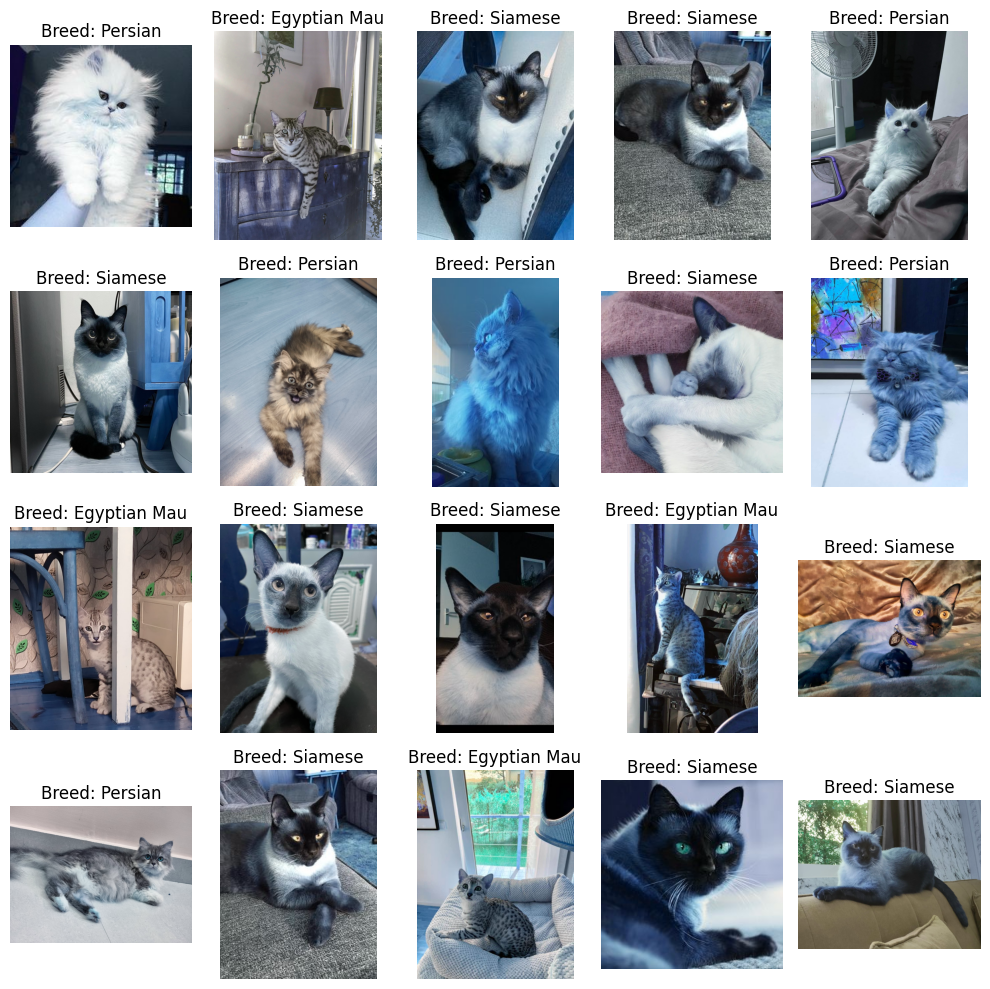

In [111]:
three_breeds_samples = all_data[all_data.breed.isin(['Persian', 'Egyptian Mau', 'Siamese'])].sample(20)

plt.figure(figsize=(10, 10))
for i, index in enumerate(three_breeds_samples.index):
    plt.subplot(4,5, i + 1)
    img = cv2.imread(three_breeds_samples.loc[[index], "id"].values[0] )
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Breed: {three_breeds_samples.loc[[index],"breed"].values[0]}')
    oput = model(**feature_extractor(img, return_tensors="pt").to(device))
    print(f'{three_breeds_samples.loc[[index],"breed"].values[0]} ->  {model.config.id2label[torch.argmax(oput.logits, dim=1).item()]}')
plt.tight_layout()
plt.show()

It's not bad for this three breeds! the accuracy is 80% and most pictures are classified as cat (5 among 1000 possibilities). It provides a good starting point for further fine-tune.

## **Preprocessing**
Since I am going to use google vit as pre-trained model, every input must fit the format of google vit. As we saw in the last section, google vit has a bulit-in preprocess to read different size of pictures. Despite the convenience, I will do preprocessing by myself because of the following reasons:
1. I want to train a model providing better results than google vit did in this specific task. Customed preprocessing allows us to try different strategies.
2. As a side project, I want to make sure that I am familiar with all necessary steps and understand how every part could impact the final result.

Let's look what does feature_extractor do.

In [112]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [113]:
input_size =feature_extractor.size
mean = feature_extractor.image_mean
std = feature_extractor.image_std
print(input_size,mean, std)

224 [0.5, 0.5, 0.5] [0.5, 0.5, 0.5]


As showed above, feature_extractor is designed to resize pictures to 224*224 and normalize them. We can define transform to implement these operations. torchvision provides many useful functions including resize, renormalize and various augment methods. As the basic attempt, I will define two transformer: one for training data and one for validation/testing data. Transform for training data contains additional augment operations while testing-transform only does what feature_extractor does. However, I will try some experiment in the next version.

In [114]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

From [vit document](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) we can see that "pixel_values" is one of the parameters used in forward. Therefore we would like to provide this feature as well. Let's define two functions.

In [115]:
def train_transform_images(images):
  images["pixel_values"] = [train_transform(image.convert("RGB")) for image in images["image"]]
  return images

def test_transform_images(images):
  images["pixel_values"] = [test_transform(image.convert("RGB")) for image in images["image"]]
  return images

In [118]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, train=True):
        self.data = dataframe
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = cv2.imread (img_path)

        if self.train:
            transformed_image = train_transform_images({"image": image})
        else:
            transformed_image = test_transform_images({"image": image})

        return transformed_image


In [119]:
train_dataset = ImageDataset(dataframe=X_train,train=True)
val_dataset = ImageDataset(dataframe=X_val, train=False)
test_dataset = ImageDataset(dataframe=X_test, train=False)

In [120]:
print(f'train_dataset: {len(train_dataset)}')
print(f'val_dataset: {len(val_dataset)}')
print(f'test_dataset: {len(test_dataset)}')

train_dataset: 8025
val_dataset: 992
test_dataset: 1002
